In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from model import ProtoTSNet

In [45]:
EXPERIMENTS_DIR = Path('experiments')

COLOR_CYCLE = ['#606060', '#AAAAAA', '#BBBBBB']
PROTO_BG = '#c1d1f077'

exp_name = 'libras_expert_protos/without/run-4/Libras'

In [46]:
def load_model(exp_name) -> ProtoTSNet:
    experiment_dir = EXPERIMENTS_DIR / exp_name
    model_path = 'models/last-epoch.pth'
    savedir = Path.cwd()
    try:
        os.chdir(experiment_dir)
        return torch.load(model_path, map_location=torch.device('cpu'))
    finally:
        os.chdir(savedir)

def retrieve_protos_details(exp_name):
    experiment_dir = Path(f'./{EXPERIMENTS_DIR}/{exp_name}/')
    with open(experiment_dir / 'params.json') as f:
        params = json.load(f)
    return params['num_classes'], params['protos_per_class'], params['proto_len_latent']

In [47]:
def visualize_matrix(matrix, exp_name):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')

    # Annotate the heatmap with the matrix values
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='white', fontsize=10)

    plt.yticks(range(matrix.shape[0]))
    plt.colorbar()
    plt.title(f'Last layer of {exp_name}')
    plt.grid(False)
    plt.xlabel('Prototypes')
    plt.ylabel('Classes')

def plot_last_layer(ppnet, protos_per_class, num_classes, exp_name):
    num_protos = protos_per_class * num_classes
    ll_weight = ppnet.last_layer.weight.to_dense().t() if ppnet.last_layer.weight.is_sparse else ppnet.last_layer.weight
    visualize_matrix(ll_weight.cpu().detach().numpy(), exp_name=exp_name)

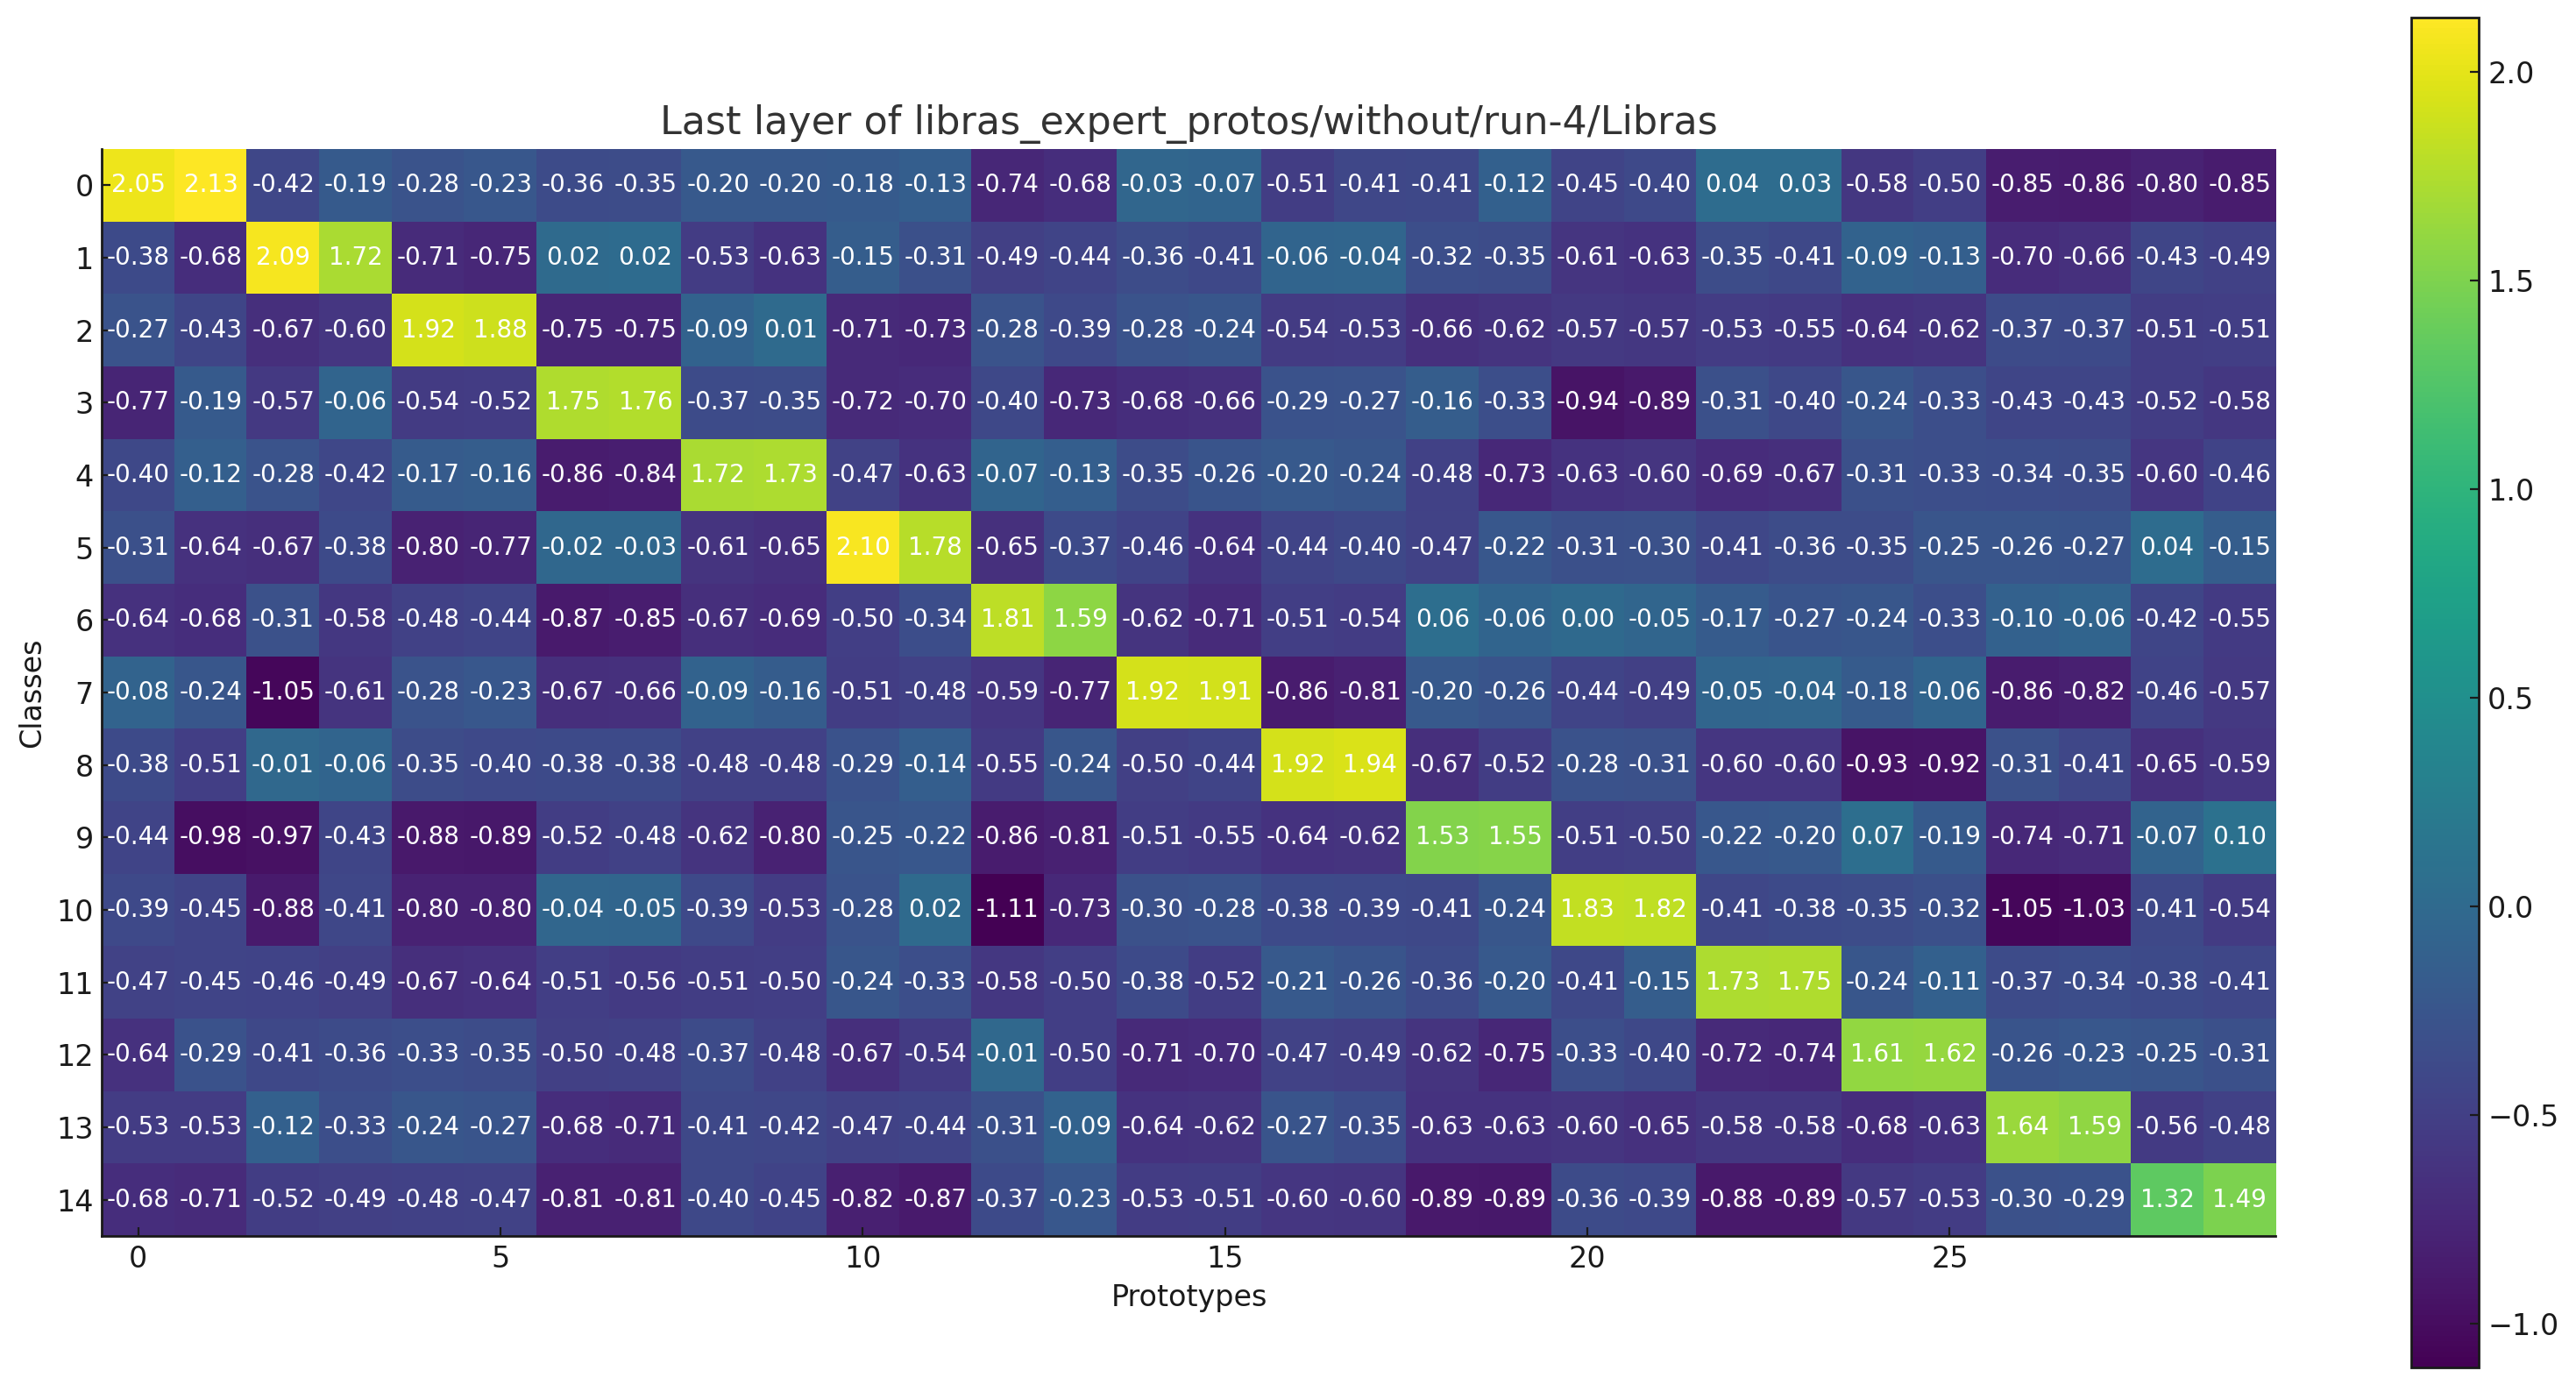

In [48]:
ptsnet = load_model(exp_name)
num_classes, protos_per_class, proto_len_latent = retrieve_protos_details(exp_name)
plt.figure(figsize=(20, 10))
plot_last_layer(ptsnet, protos_per_class, num_classes, exp_name)
plt.show()

In [49]:
def plot_single_feature(ax, y, rf_start, rf_end, feat_importance, color):
    x = range(len(y))
    
    if rf_start > 0:
        ax.plot(x[:rf_start+1], y[:rf_start+1], color=color)
    line, = ax.plot(x[rf_start:rf_end], y[rf_start:rf_end], color=color)
    if rf_end < len(y):
        ax.plot(x[rf_end-1:], y[rf_end-1:], color=color)
    return line

def visualize_proto(ts, proto_range, ax=None, proto_bg='#c1d1f077', y_lim=None):
    if ax is None:
        ax = plt.gca()
    lines = []
    labels = []

    rf_start = proto_range[0]
    rf_end = proto_range[1]

    for i, feat in enumerate(range(ts.shape[0])):
        lines.append(plot_single_feature(ax, ts[feat], rf_start, rf_end, feat_importance=1, color=COLOR_CYCLE[i%len(COLOR_CYCLE)]))
        labels.append(f'Feature {feat}')
    ax.set_xlim(0, ts.shape[1]-1)
    y_min_max = (np.min(ts[:, :-1]), np.max(ts[:, :-1]))
    y_range = y_min_max[1] - y_min_max[0]
    if y_lim is None:
        ax.set_ylim(y_min_max[0] - 0.2*y_range, y_min_max[1] + 0.2*y_range)
    else:
        ax.set_ylim(y_lim)
    y_lim = ax.get_ylim()
    ax.fill_between(range(rf_start, rf_end), *ax.get_ylim(), color=proto_bg)
    ax.set_ylim(y_lim)

In [50]:
epoch_num = 200

protos_dir = Path(f'./{EXPERIMENTS_DIR}/{exp_name}/protos/epoch-{epoch_num}')
prototype_info = np.load(protos_dir / f'bounds{epoch_num}.npy')

Proto details:
Number of classes: 15
Prototypes per class: 2
Proto length: 22


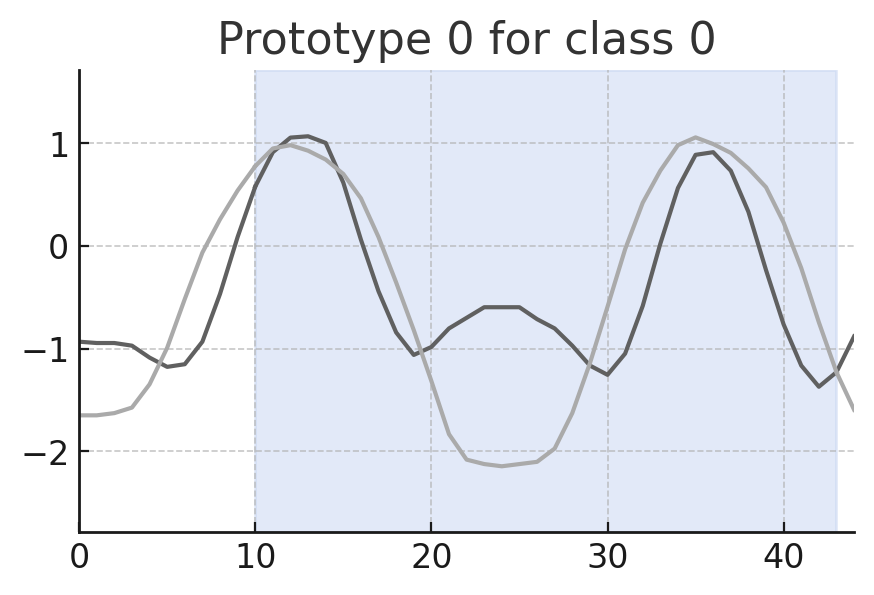

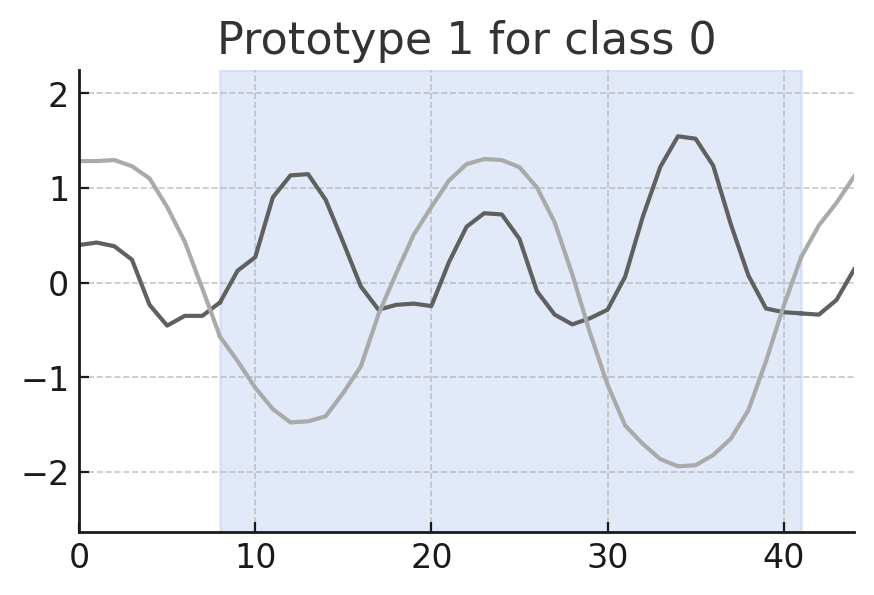

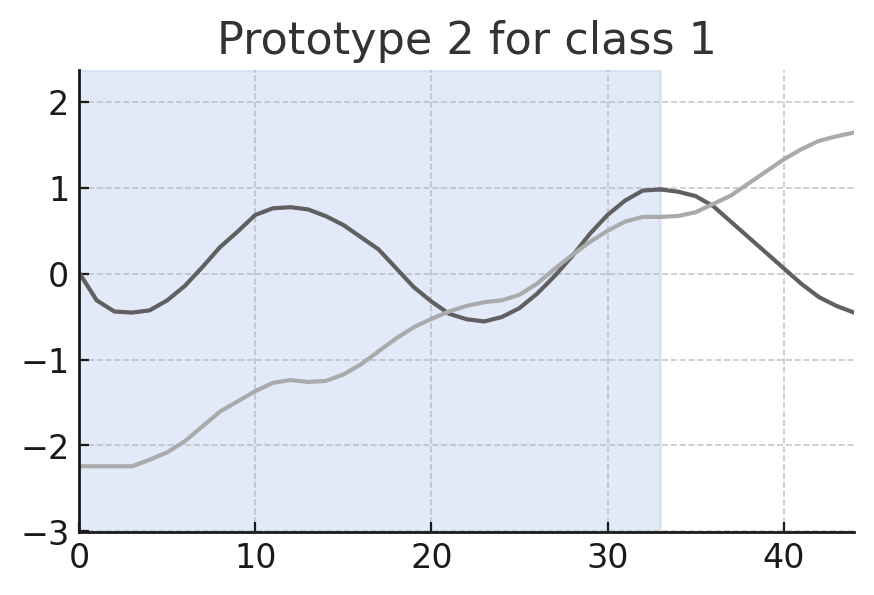

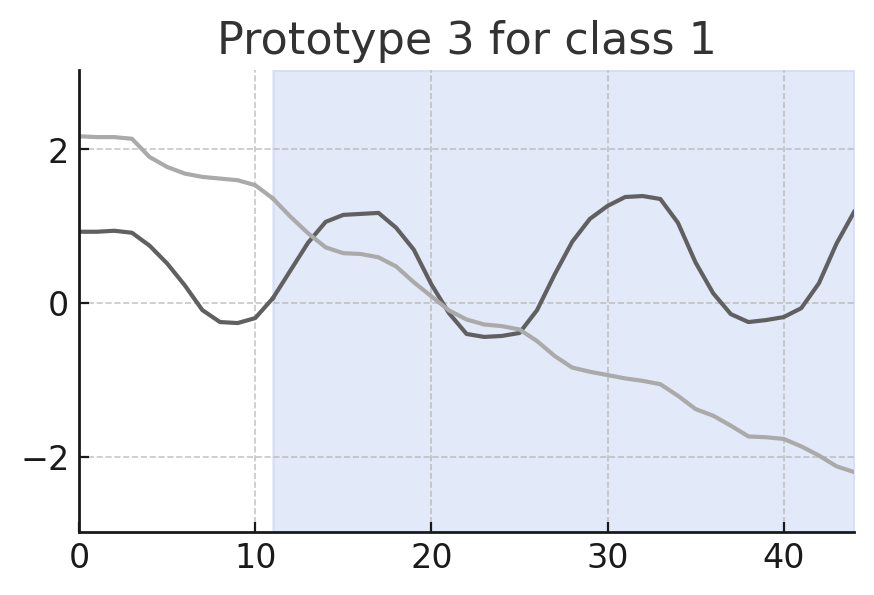

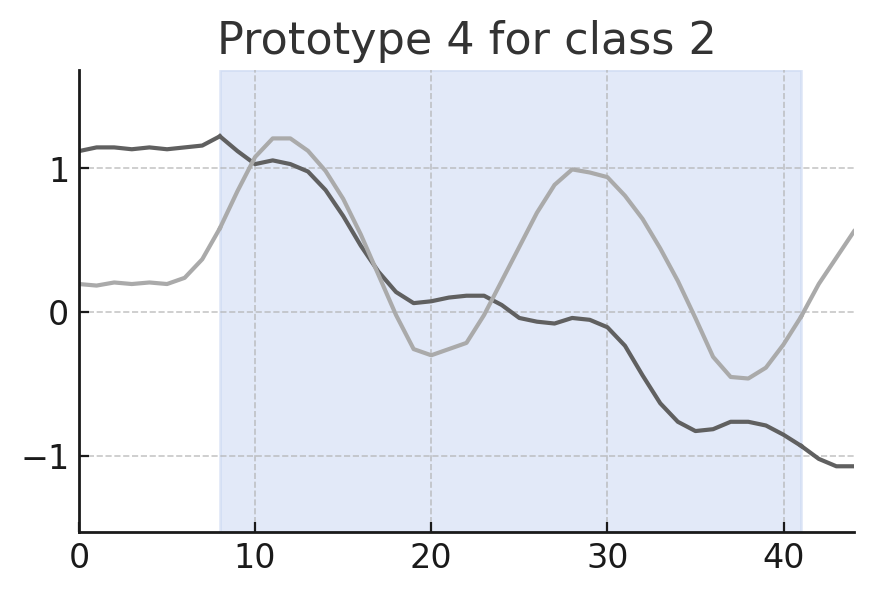

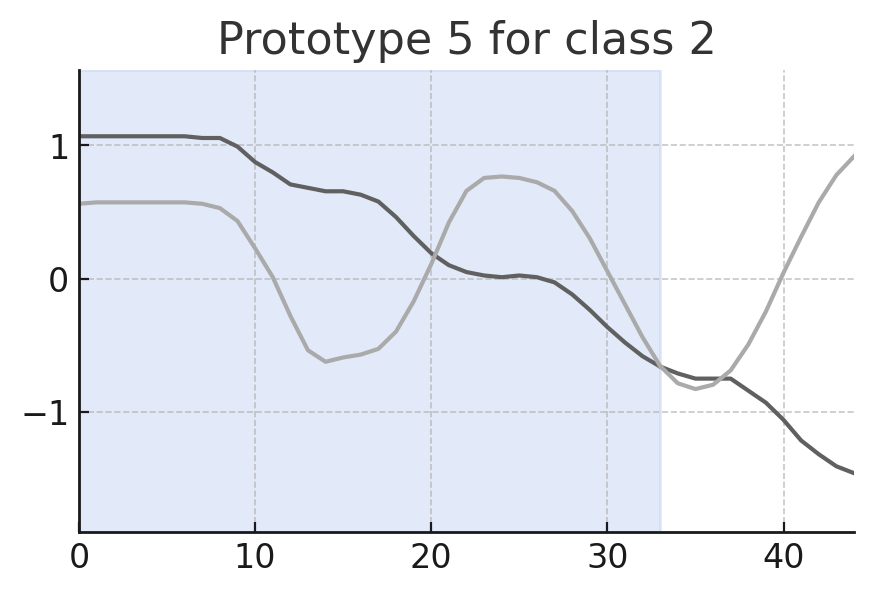

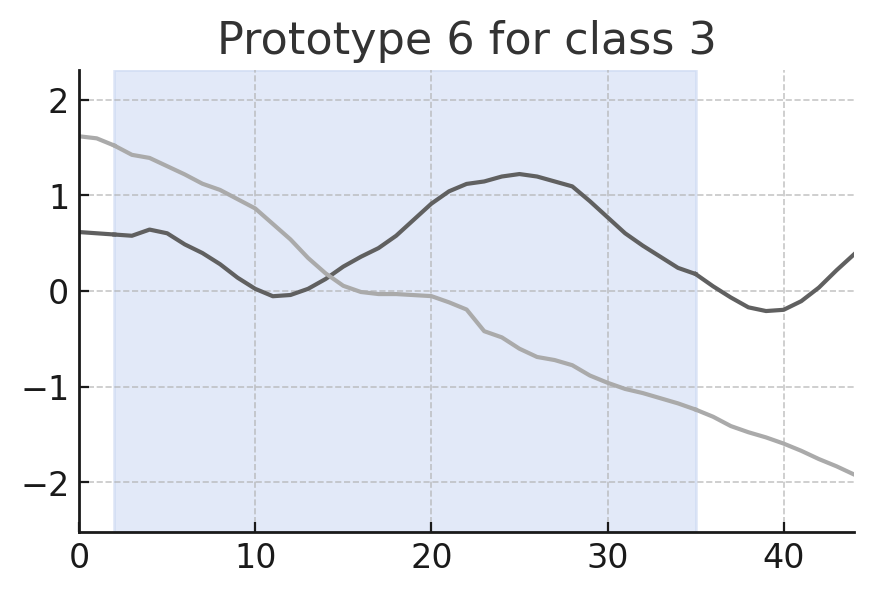

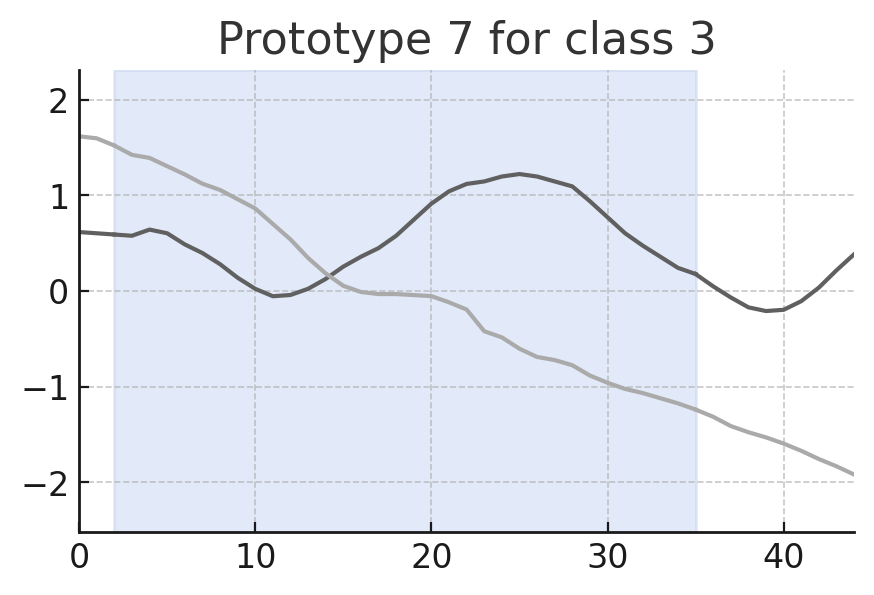

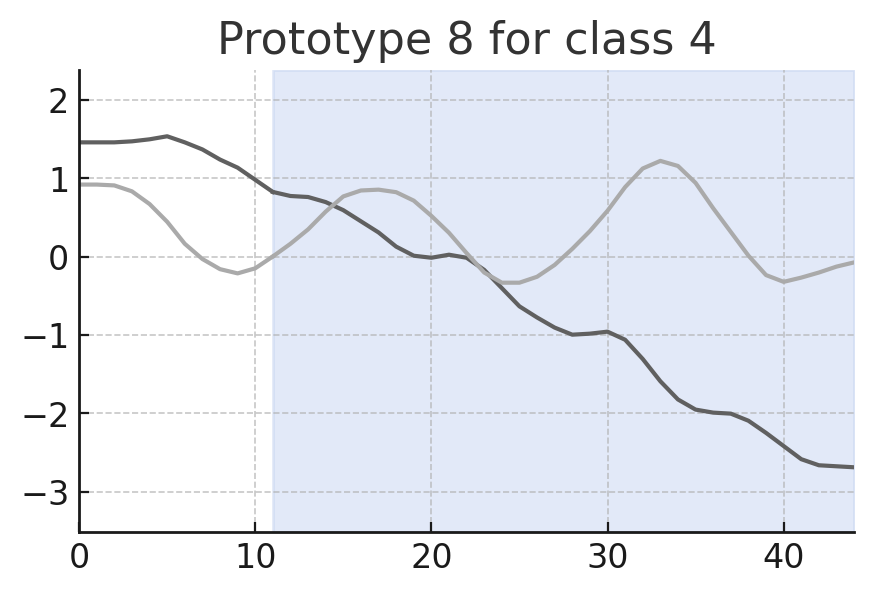

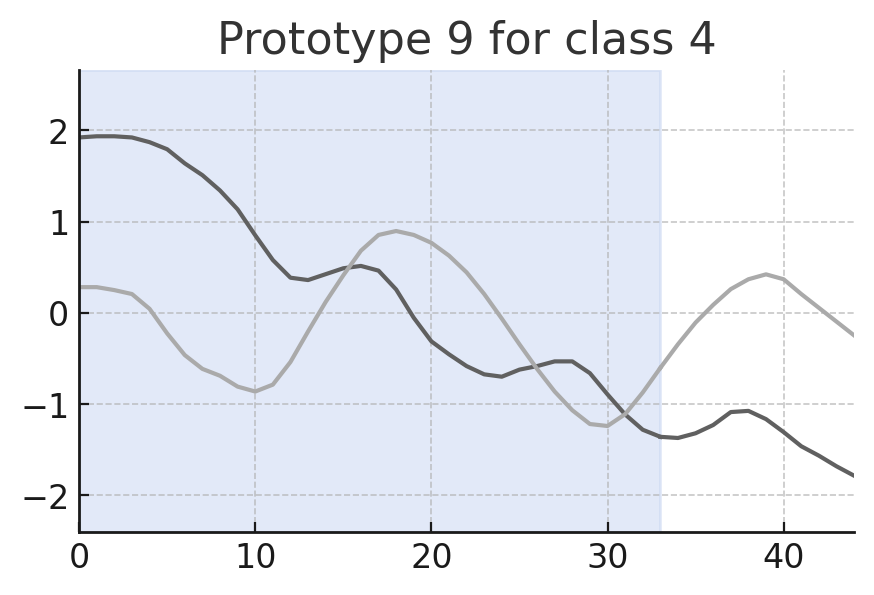

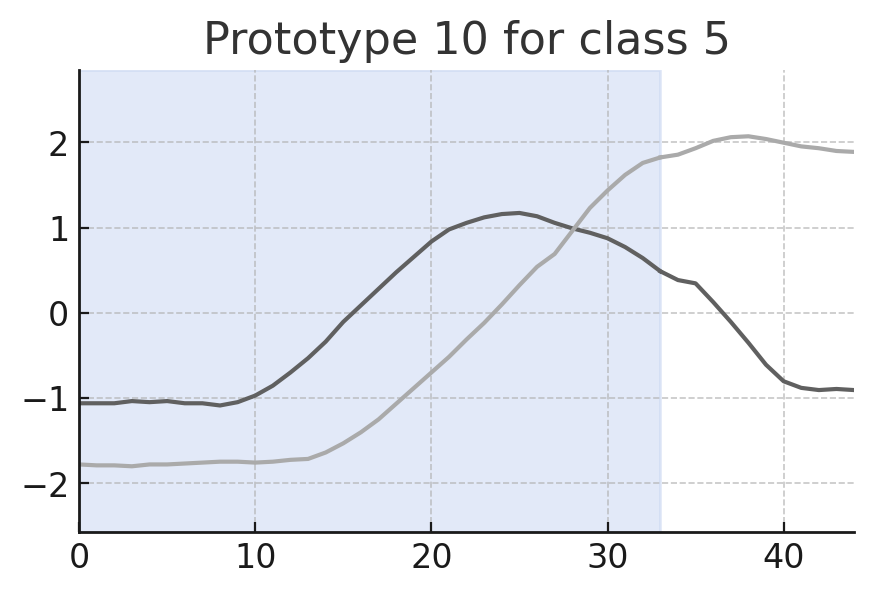

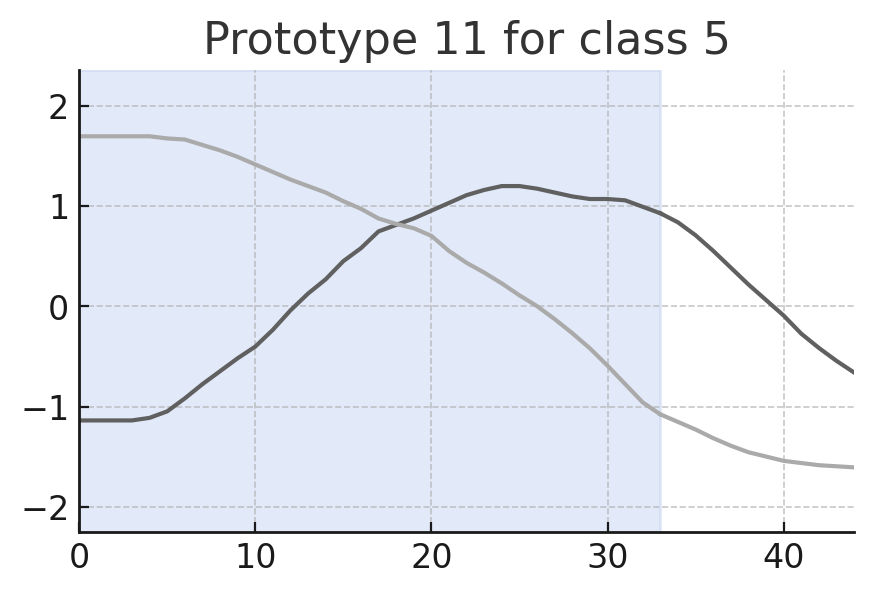

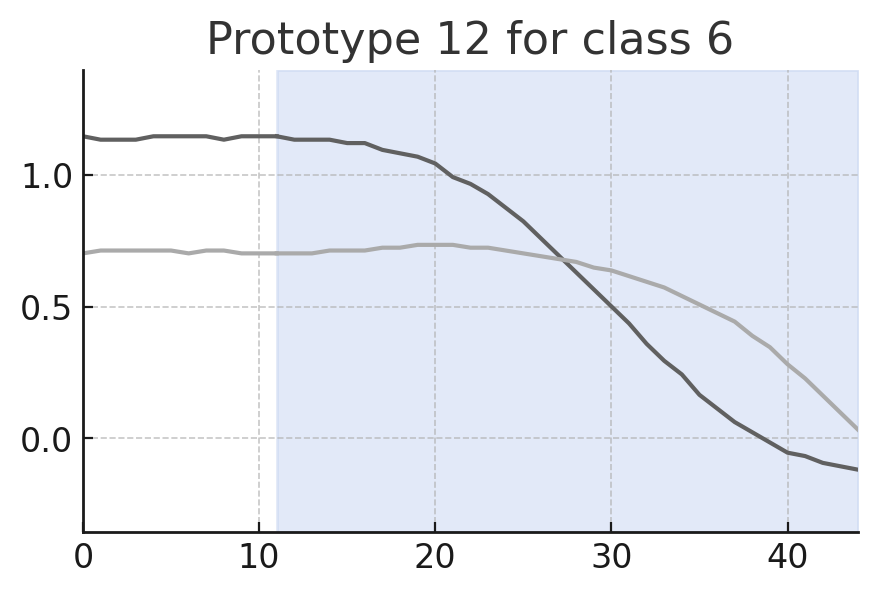

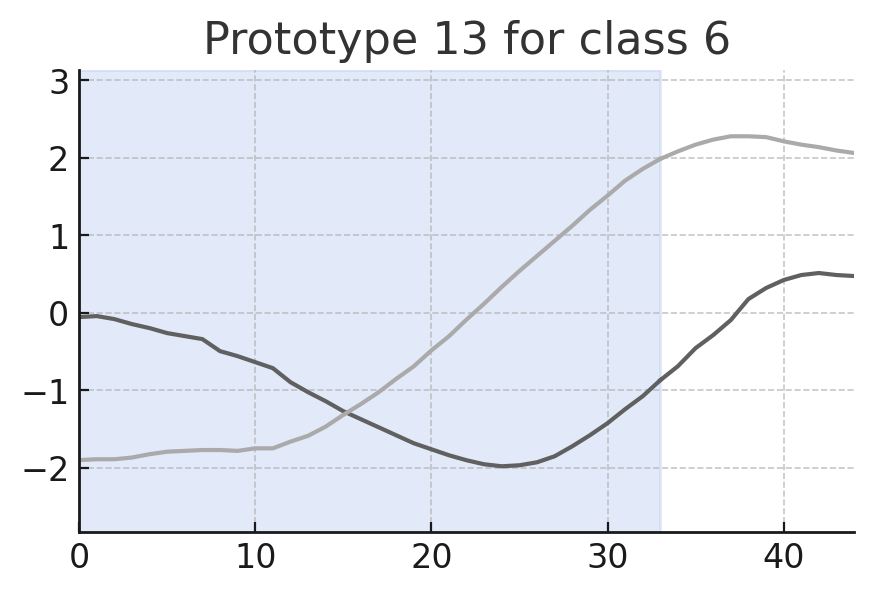

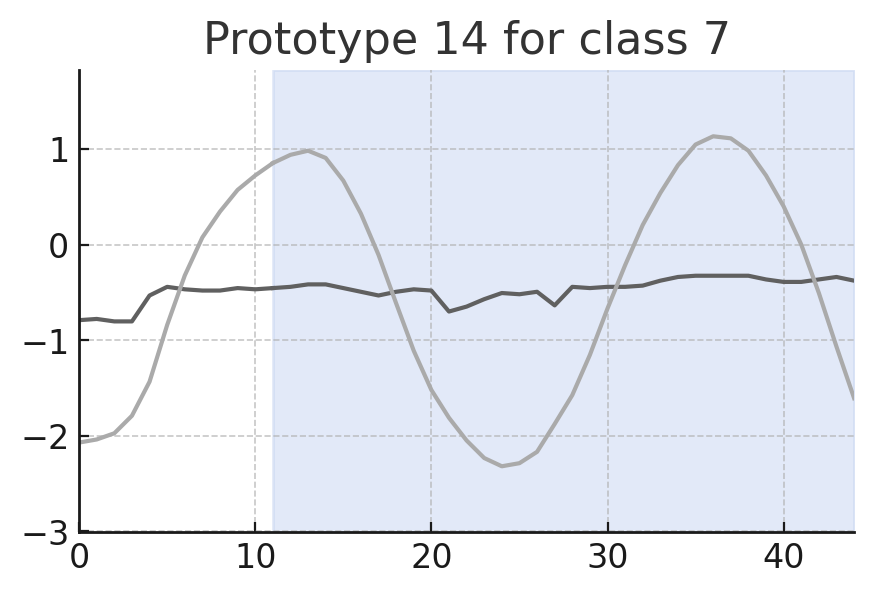

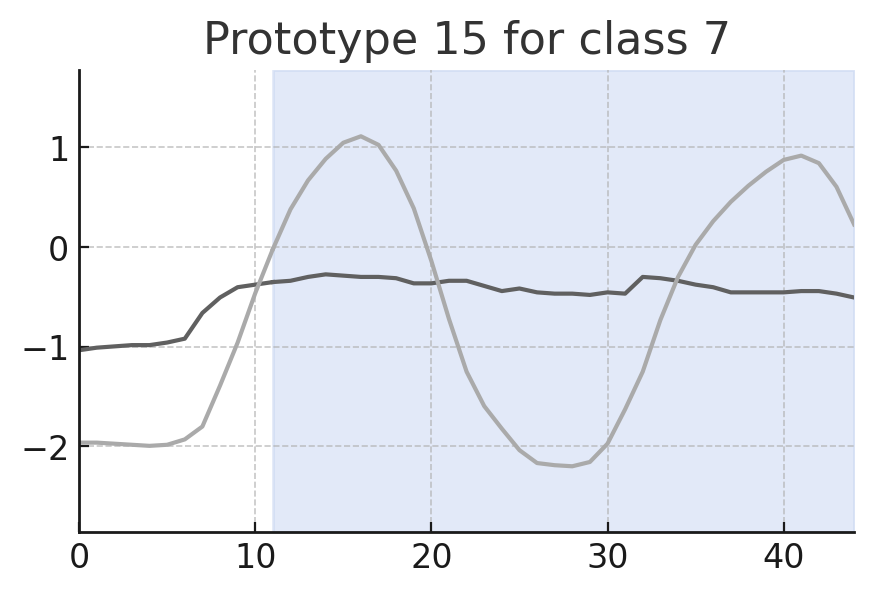

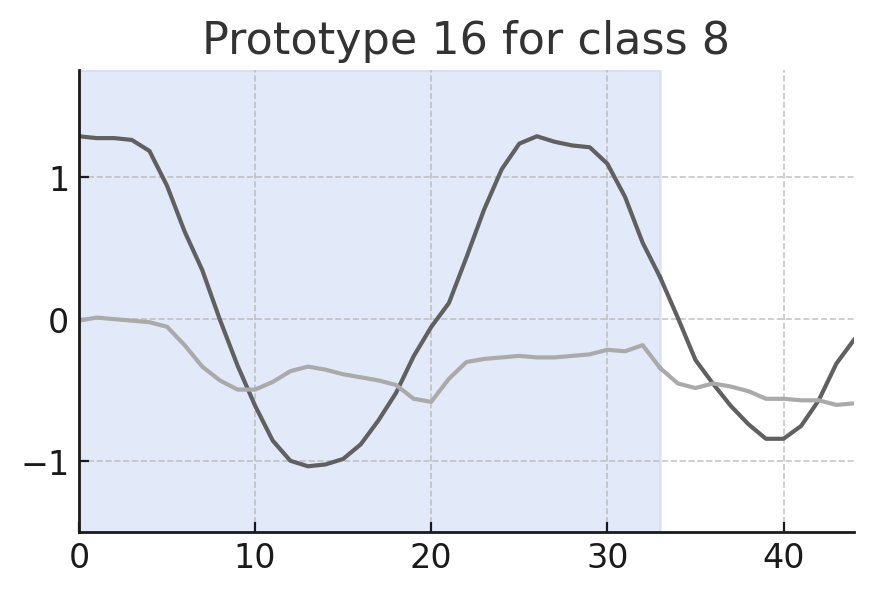

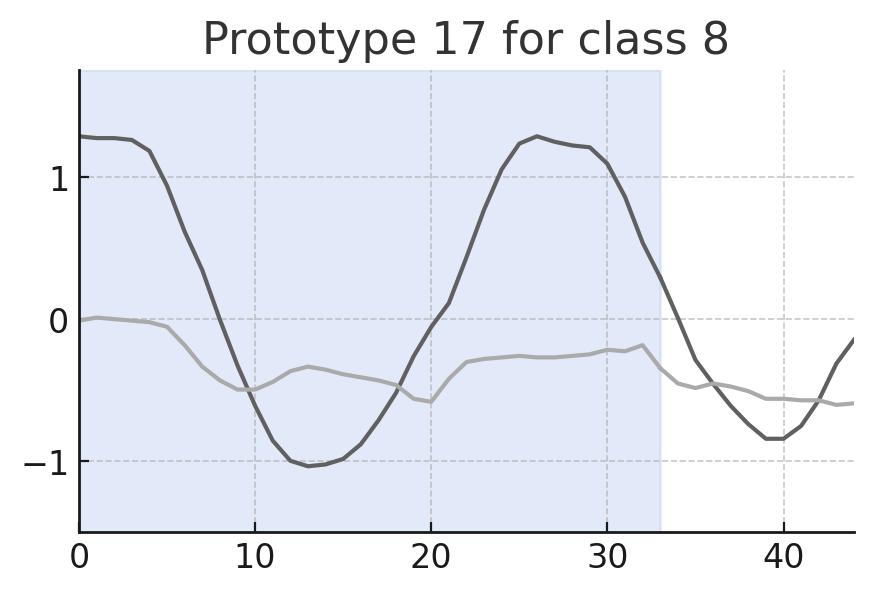

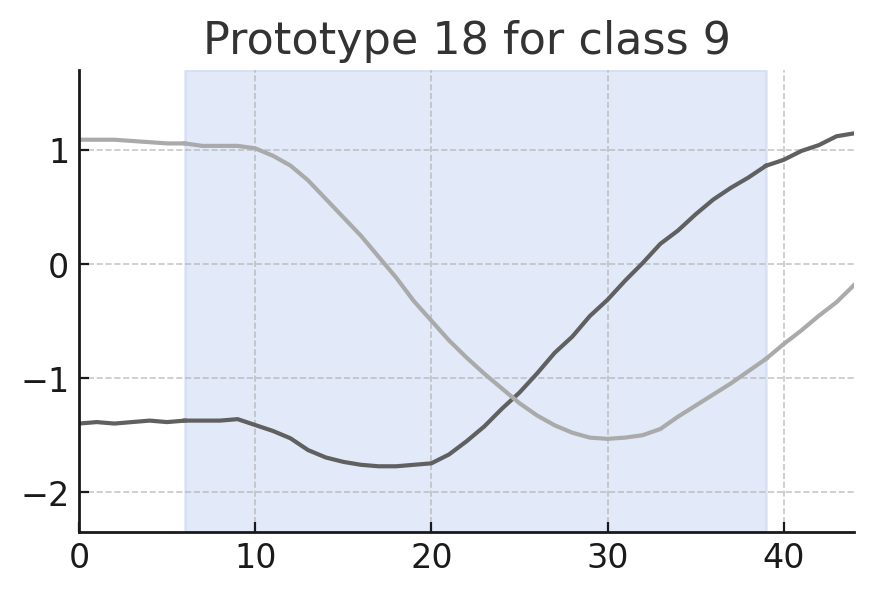

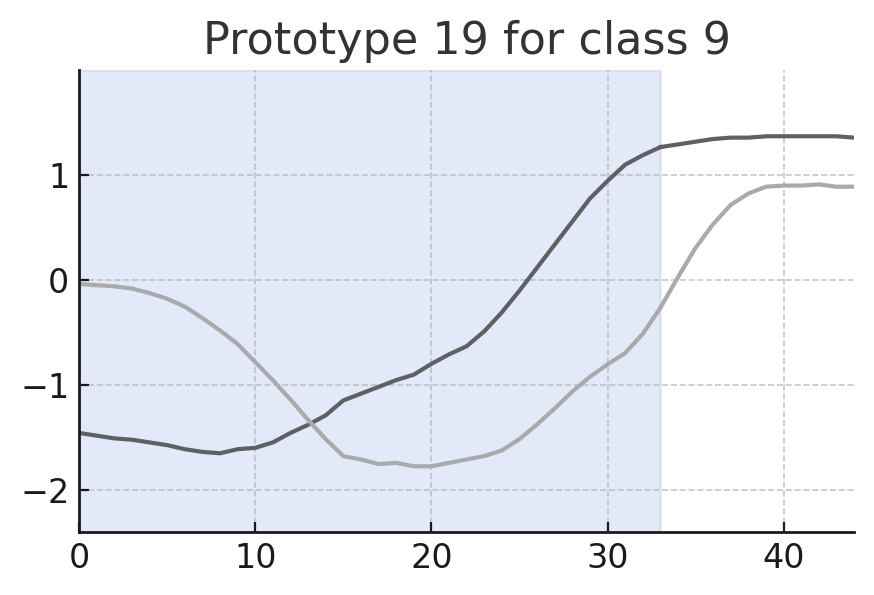

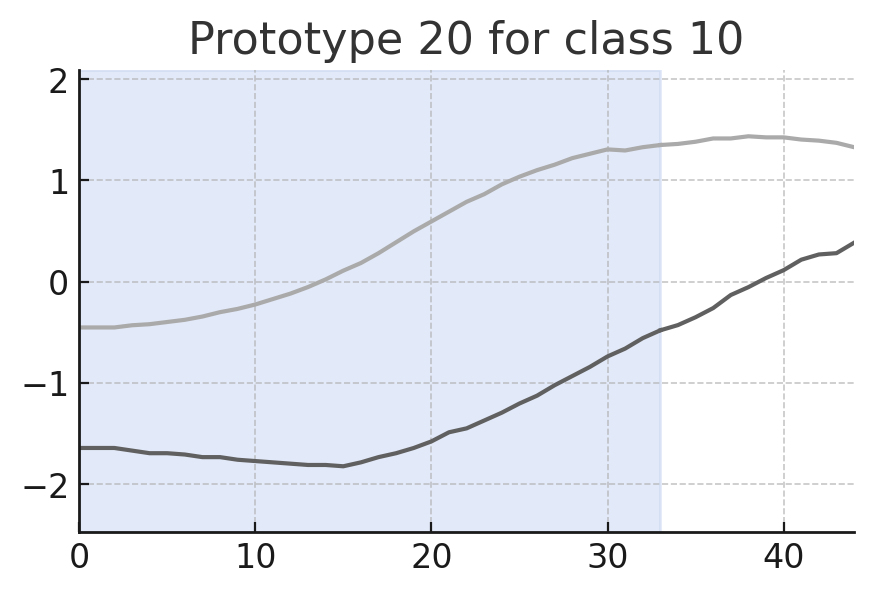

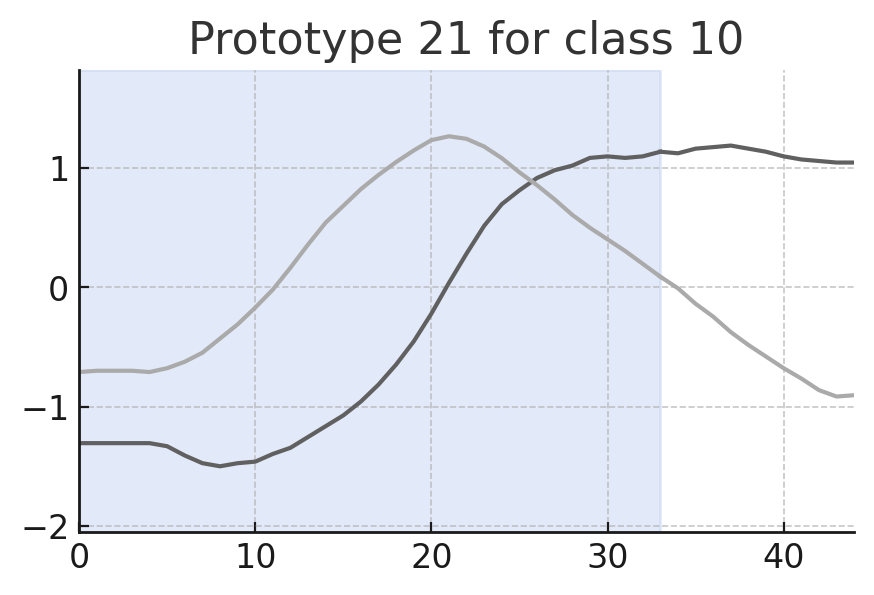

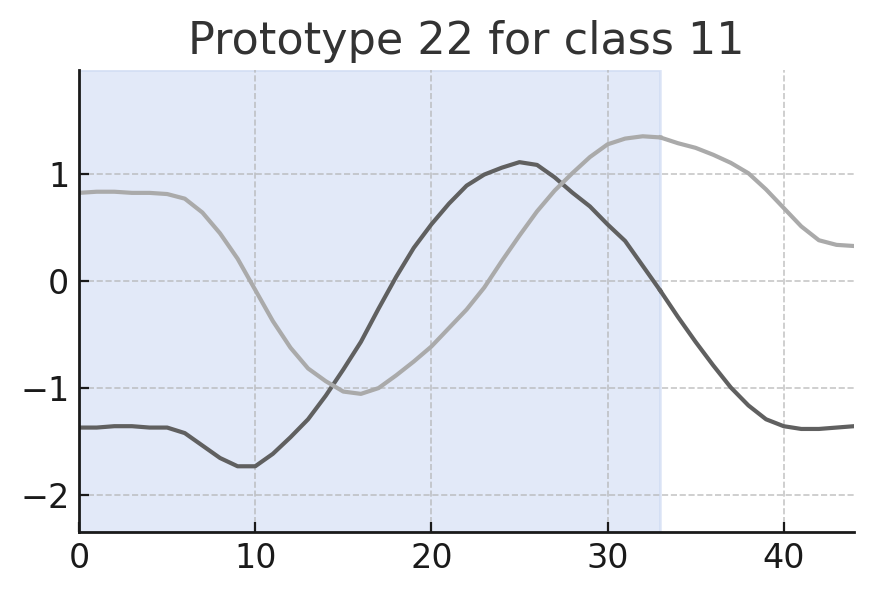

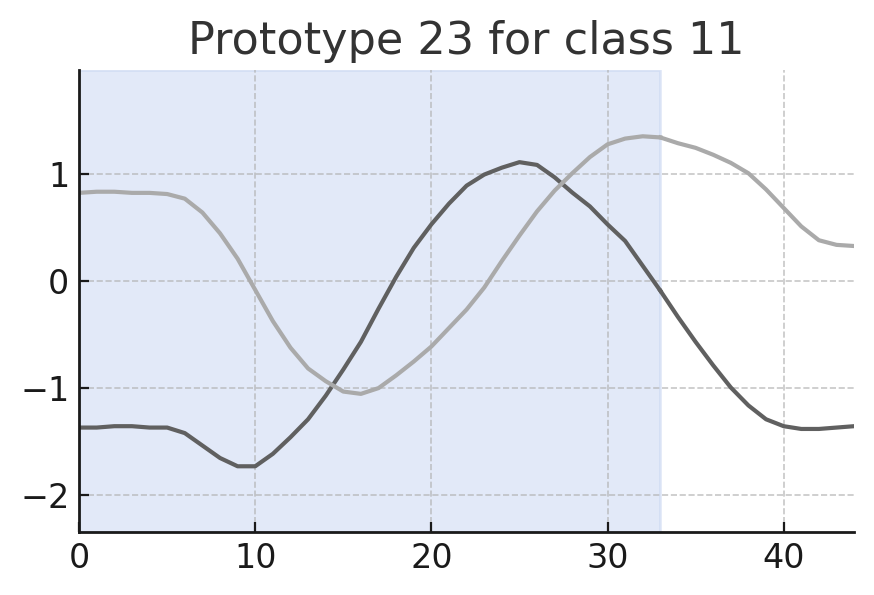

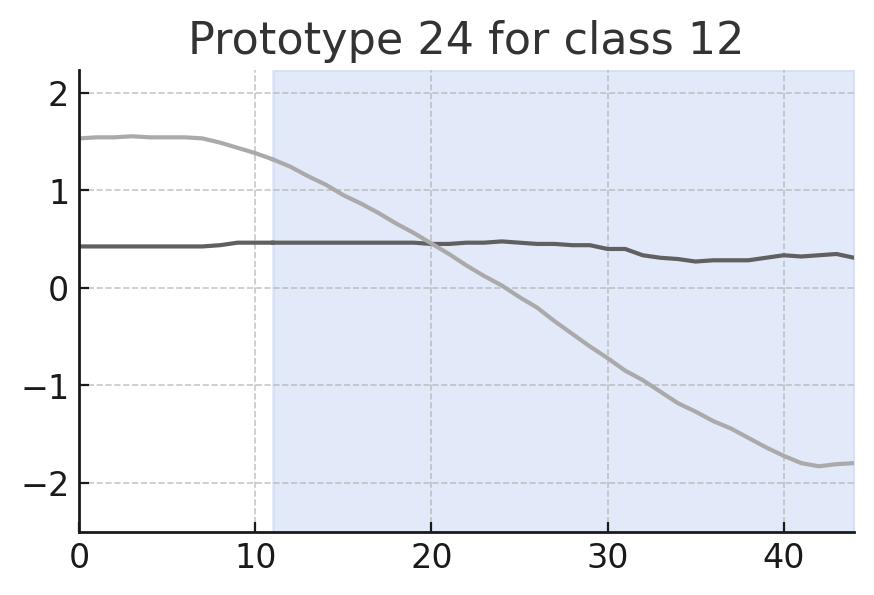

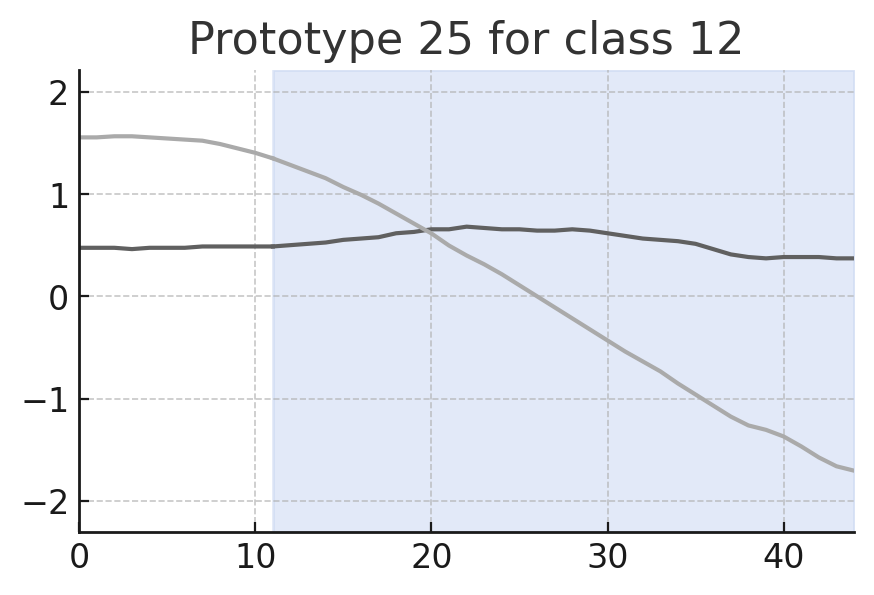

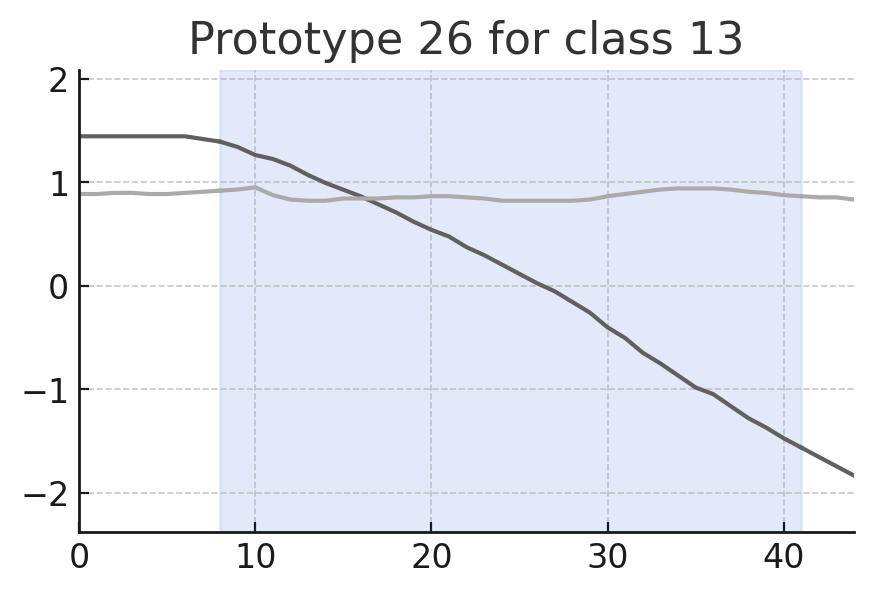

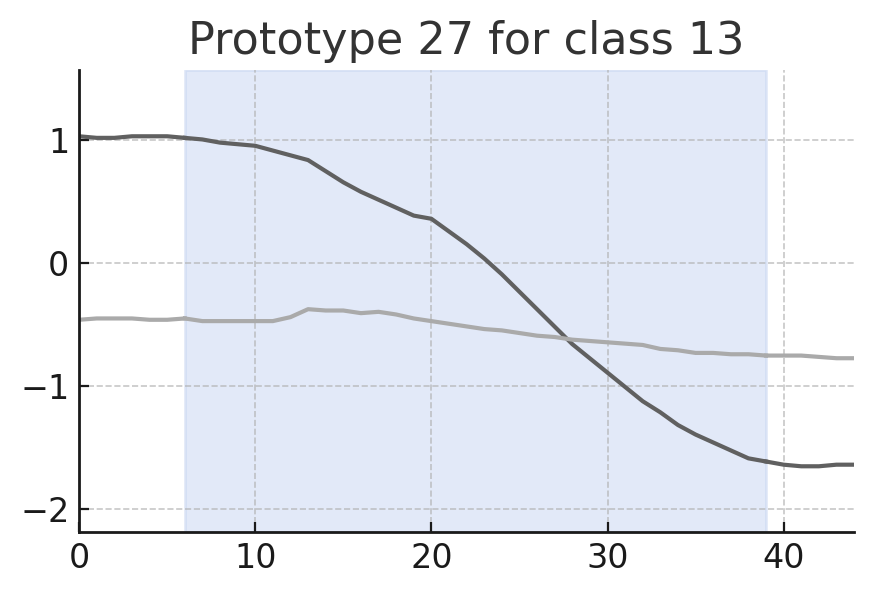

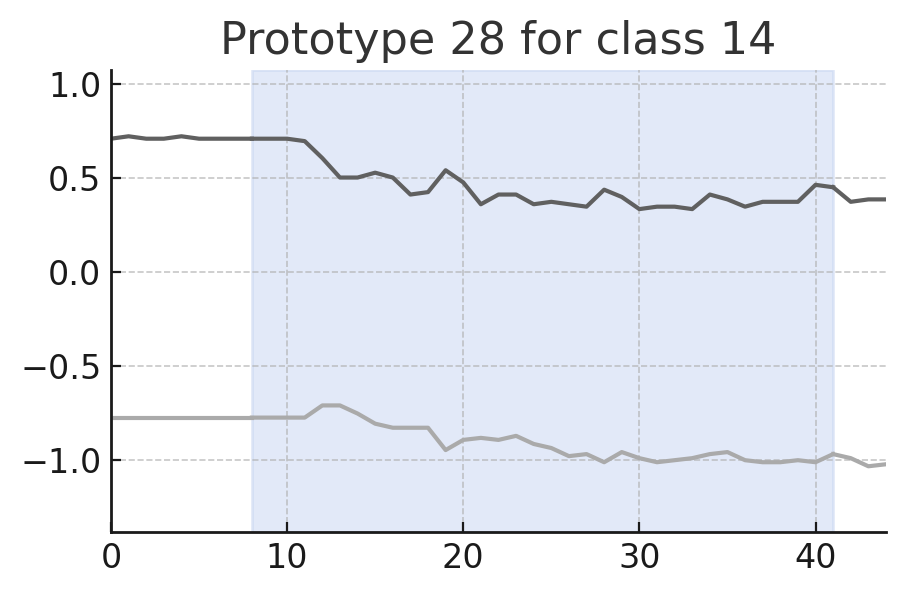

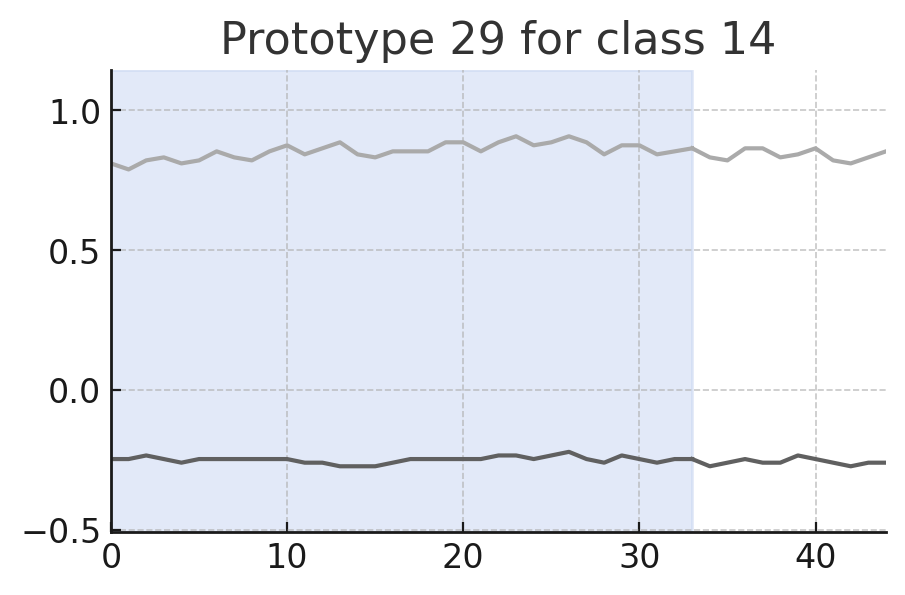

In [51]:
num_classes, protos_per_class, proto_len_latent = retrieve_protos_details(exp_name)

# print('Final layer accuracy: ')
print('Proto details:')
print(f'Number of classes: {num_classes}')
print(f'Prototypes per class: {protos_per_class}')
print(f'Proto length: {proto_len_latent}')

for proto_num in range(num_classes*protos_per_class):
    proto = np.load(protos_dir / f'prototype-ts-original_with_self_act{proto_num:03d}.npy')
    receptive_field_size = 13 + proto_len_latent - 1
    
    
    # receptive_field_size = proto_len - 1
    max_activation_idx = np.argmax(proto[:, -1])
    rf_start = max_activation_idx - receptive_field_size // 2
    rf_start = 0 if rf_start < 0 else rf_start
    rf_end = rf_start + receptive_field_size
    rf_end = proto.shape[0] if rf_end > proto.shape[0] else rf_end
    if rf_start == 0:
        rf_end = rf_start + receptive_field_size
    if rf_end == proto.shape[0]:
        rf_start = proto.shape[0] - receptive_field_size
    np.savetxt(f'target_protos_libras/class_{proto_num // protos_per_class}_proto_{proto_num % protos_per_class}.txt', proto[:, :-1].transpose()[::-1][:, rf_start:rf_end])
    plt.figure(figsize=(5, 3))
    visualize_proto(proto[:, :-1].transpose()[::-1], (rf_start, rf_end), proto_bg=PROTO_BG)
    plt.title(f'Prototype {proto_num} for class {proto_num // protos_per_class}')
    plt.show()

In [ ]:
epoch_num = 200

protos_dir = Path(f'./{EXPERIMENTS_DIR}/{exp_name}/protos/epoch-{epoch_num}')
prototype_info = np.load(protos_dir / f'bounds{epoch_num}.npy')
prototype_img_identity = prototype_info[:, -1]

# proto = np.load(f'./{EXPERIMENTS_DIR}/{exp_name}/protos/epoch-{epoch_num}/prototype-ts-original_with_self_act{proto_num:03d}.npy')
# receptive_field_size = 13 + ppnet.prototype_shape[2] - 1
# # receptive_field_size = proto_len - 1
# max_activation_idx = np.argmax(proto[:, -1])
# rf_start = max_activation_idx - receptive_field_size // 2
# rf_start = 0 if rf_start < 0 else rf_start
# rf_end = rf_start + receptive_field_size + 1
# rf_end = proto.shape[0] if rf_end > proto.shape[0] else rf_end
# visualize_proto(proto[:, :-1].transpose()[::-1], (rf_start, rf_end), ax=axs[0, 0], y_lim=(-0.1, 0.9), proto_bg=PROTO_BG)
# axs[0, 0].set_facecolor('#e9e9e9')
# axs[0, 0].label_outer()
# # axs[0, 0].set_xlabel('Prototype')

for ax_idx, ex_idx in enumerate(ex_indices, start=1):
    ex_npy = dataset.test.X[ex_idx]
    ex = torch.tensor([ex_npy])
    ex_label = dataset.test.y[ex_idx]

    logits, min_distances = ppnet(ex)
    conv_output, distances = ppnet.push_forward(ex)
    prototype_activations = ppnet.distance_2_similarity(min_distances)
    prototype_activation_patterns = ppnet.distance_2_similarity(distances)

    tables = []
    for i in range(logits.size(0)):
        tables.append((torch.argmax(logits, dim=1)[i].item(), ex_label))
        print(str(i) + ' ' + str(tables[-1]))

    idx = 0
    predicted_cls = tables[idx][0]
    correct_cls = tables[idx][1]
    print('Predicted: ' + str(predicted_cls))
    print('Actual: ' + str(correct_cls))

    print('Most activated 10 prototypes for this serie:')
    array_act, sorted_indices_act = torch.sort(prototype_activations[idx])
    for i in range(1,4):
        print(f'top {i} activated prototype for this image:')
        # save_prototype(os.path.join(save_analysis_path, 'most_activated_prototypes',
        #                             'top-%d_activated_prototype.png' % i),
        #                start_epoch_number, sorted_indices_act[-i].item())
        # save_prototype_original_img_with_bbox(fname=os.path.join(save_analysis_path, 'most_activated_prototypes',
        #                                                          'top-%d_activated_prototype_in_original_pimg.png' % i),
        #                                       epoch=start_epoch_number,
        #                                       index=sorted_indices_act[-i].item(),
        #                                       bbox_height_start=prototype_info[sorted_indices_act[-i].item()][1],
        #                                       bbox_height_end=prototype_info[sorted_indices_act[-i].item()][2],
        #                                       bbox_width_start=prototype_info[sorted_indices_act[-i].item()][3],
        #                                       bbox_width_end=prototype_info[sorted_indices_act[-i].item()][4],
        #                                       color=(0, 255, 255))
        # save_prototype_self_activation(os.path.join(save_analysis_path, 'most_activated_prototypes',
        #                                             'top-%d_activated_prototype_self_act.png' % i),
        #                                start_epoch_number, sorted_indices_act[-i].item())
        print('prototype index: {0}'.format(sorted_indices_act[-i].item()))
        print('prototype class identity: {0}'.format(prototype_img_identity[sorted_indices_act[-i].item()]))
        # if prototype_max_connection[sorted_indices_act[-i].item()] != prototype_img_identity[sorted_indices_act[-i].item()]:
        #     print('prototype connection identity: {0}'.format(prototype_max_connection[sorted_indices_act[-i].item()]))
        print('activation value (similarity score): {0}'.format(array_act[-i]))
        print('last layer connection with predicted class: {0}'.format(ppnet.last_layer.weight[predicted_cls][sorted_indices_act[-i].item()]))
        
        activation_pattern = prototype_activation_patterns[idx][sorted_indices_act[-i].item()].detach().cpu().numpy()
        # upsampled_activation_pattern = cv2.resize(activation_pattern, dsize=(img_size, img_size),
        #                                           interpolation=cv2.INTER_CUBIC)
        
        # show the most highly activated patch of the image by this prototype
        high_act_patch_indices = find_high_activation_crop(activation_pattern, proto_len=ppnet.prototype_shape[2], ts_len=ex.shape[2])
        # high_act_patch = ex[high_act_patch_indices[0]:high_act_patch_indices[1]]
        print('most highly activated patch of the chosen image by this prototype:')
        print(high_act_patch_indices)
        visualize_proto(ex_npy[::-1], high_act_patch_indices, ax=axs[0, ax_idx], y_lim=(-0.1, 0.9), proto_bg=PROTO_BG)
        axs[0, ax_idx].label_outer()
        # #plt.axis('off')
        # plt.imsave(os.path.join(save_analysis_path, 'most_activated_prototypes',
        #                         'most_highly_activated_patch_by_top-%d_prototype.png' % i),
        #            high_act_patch)
        # print('most highly activated patch by this prototype shown in the original image:')
        # imsave_with_bbox(fname=os.path.join(save_analysis_path, 'most_activated_prototypes',
        #                         'most_highly_activated_patch_in_original_img_by_top-%d_prototype.png' % i),
        #                  img_rgb=original_img,
        #                  bbox_height_start=high_act_patch_indices[0],
        #                  bbox_height_end=high_act_patch_indices[1],
        #                  bbox_width_start=high_act_patch_indices[2],
        #                  bbox_width_end=high_act_patch_indices[3], color=(0, 255, 255))
        
        # # show the image overlayed with prototype activation map
        # rescaled_activation_pattern = upsampled_activation_pattern - np.amin(upsampled_activation_pattern)
        # rescaled_activation_pattern = rescaled_activation_pattern / np.amax(rescaled_activation_pattern)
        # heatmap = cv2.applyColorMap(np.uint8(255*rescaled_activation_pattern), cv2.COLORMAP_JET)
        # heatmap = np.float32(heatmap) / 255
        # heatmap = heatmap[...,::-1]
        # overlayed_img = 0.5 * original_img + 0.3 * heatmap
        # print('prototype activation map of the chosen image:')
        # #plt.axis('off')
        # plt.imsave(os.path.join(save_analysis_path, 'most_activated_prototypes',
        #                         'prototype_activation_map_by_top-%d_prototype.png' % i),
        #            overlayed_img)
        # print('--------------------------------------------------------------')